In [93]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

torch_scalar = torch.tensor(3.14)
torch_vector = torch.tensor([1, 2, 3, 4])
torch_matrix = torch.tensor([[1, 2, ],
                             [3, 4, ],
                             [5, 6, ],
                             [7, 8, ]])
torch_tensor3d = torch.tensor([
    [
        [1, 2, 3],
        [4, 5, 6],
    ],
    [
        [7, 8, 9],
        [10, 11, 12],
    ],
    [
        [13, 14, 15],
        [16, 17, 18],
    ],
    [
        [19, 20, 21],
        [22, 23, 24],
    ]
])

# every time a list is nested into another list, we add another diemension 

In [8]:
torch_tensor3d.shape

torch.Size([4, 2, 3])

We can also convert numpy to tensor

In [13]:
import numpy as np
x_np = np.random.random((4,4)) # 4x4 matrix
# convert np matrix to tensor
x_tensor = torch.tensor(x_np)
print(x_tensor)
# when using torch.tensor, torch takes the dtype of the input

tensor([[0.0857, 0.6946, 0.0607, 0.6507],
        [0.1724, 0.9027, 0.2018, 0.6479],
        [0.3977, 0.7245, 0.9662, 0.7524],
        [0.0373, 0.4417, 0.1277, 0.7542]], dtype=torch.float64)


In [14]:
print(x_np.dtype, x_tensor.dtype)

float64 torch.float64


In [15]:
# cast the value to the float 
torch.tensor(x_np, dtype=torch.float32)

tensor([[0.0857, 0.6946, 0.0607, 0.6507],
        [0.1724, 0.9027, 0.2018, 0.6479],
        [0.3977, 0.7245, 0.9662, 0.7524],
        [0.0373, 0.4417, 0.1277, 0.7542]])

## Comparing CPU vs GPU performance on matrix multiplication

In [24]:
import timeit
x = torch.rand(2**11, 2**11)
print(x.shape)
# doing it on the cpu
time_cpu = timeit.timeit("x@x", globals=globals(), number=100)

torch.Size([2048, 2048])


In [32]:
# doing it on the gpu
print(torch.cuda.is_available()) # if true, cude is available
device = torch.device("cuda") # create reference to gpu

# move x to the gpu
x = x.to(device)
time_gpu = timeit.timeit("x@x", globals=globals(), number=100)

True


In [33]:
print("CPU time: ", time_cpu, "\nGPU time: ", time_gpu)

CPU time:  11.311850899999968 
GPU time:  1.0788138000000345


In [35]:
# convert x back to cpu and then numpy
x.cpu().numpy()

array([[0.42272305, 0.7266976 , 0.10263491, ..., 0.28082168, 0.8599846 ,
        0.33988428],
       [0.9037032 , 0.7249599 , 0.13920534, ..., 0.12979019, 0.91330147,
        0.7644448 ],
       [0.05445975, 0.97781855, 0.5701904 , ..., 0.3954869 , 0.07081652,
        0.64902115],
       ...,
       [0.28869182, 0.07162386, 0.0883581 , ..., 0.04194361, 0.2546708 ,
        0.3390283 ],
       [0.17911011, 0.55419594, 0.12728584, ..., 0.89835227, 0.27728236,
        0.8851659 ],
       [0.9822597 , 0.2720968 , 0.777319  , ..., 0.0232327 , 0.35091996,
        0.79880726]], dtype=float32)

## Automatic Differentation
Pytorch can compute derivatives automatically for us.

<AxesSubplot:>

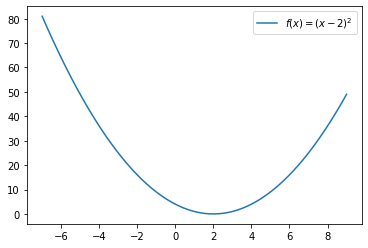

In [42]:
def f(x):
    return torch.pow((x-2),2)

x_axis_vals = np.linspace(-7,9,100)
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()

sns.lineplot(x = x_axis_vals,y= y_axis_vals, label = '$f(x)=(x-2)^2$')


Doing the differentation in pytorch with a small example.

In [55]:
x = torch.tensor([-3.5], requires_grad=True) # requir_grad flag, tells pytorch to keep track of the gradient
print(x.grad)
value = f(x)
print(value)

None
tensor([30.2500], grad_fn=<PowBackward0>)


The first part tells us the result value i.e. the result of $(3.5-2)^2$. Since we keep track of the gradients, we can tell pytorch to go back in time.

In [54]:
value.backward() # computes the gradient wrt to the graph leaves
print(x.grad) 

tensor([-11.])


The above value is the gradient for the value $x = -3.5$, hence it shows the value of the first derivative of the function $f(x)$ evaluated at $x=-3.5$. We can make the function $f(x)$ do almost everything as long as it is implemented using PyTorch functions.

Next, we will use pytorch to find the minimum of the above function $f(x)$.

In [63]:
# start with a guess
x = torch.tensor([-3.5], requires_grad=True)
x_cur = x.clone()
x_prev = x_cur*100
eps = 1e-10

eta = 0.01 # learning rate

# the while defines, when to stop the optimization
while torch.linalg.norm(x_cur-x_prev)>eps:
    x_prev = x_cur.clone()
    value = f(x)
    value.backward() # compute the gradient of f(x)
    
    # go a step
    x.data -= eta*x.grad

    x.grad.zero_() # after making the step, reset the gradient

    x_cur = x.data

print(x_cur)

tensor([2.0000])


## Parameters and Optimizers

In [73]:
x_param = torch.nn.Parameter(torch.tensor([-3.5]), requires_grad=True)
optimizer = torch.optim.SGD([x_param], lr = eta) # optimizer keeps track on the param values

# do the same as before, but do it for 20 epochs (how often does the dataset see the whole data?)
for epoch in range(10000):
    optimizer.zero_grad() # reset the gradients in the underyling params
    loss = f(x_param)
    # calculate gradient for the current value
    loss.backward()

    # go one step 
    optimizer.step() # Why does the optimizer know from the loss? since the loss uses the x_param, which is tracked by the optimizer.

print(x_param.data)

tensor([2.0000])


## Loading a Dataset

In [75]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml
X,y = fetch_openml("mnist_784", version=1, return_X_y=True)
print(X.shape)

(70000, 784)


Next, we create a simple dataset subclassing the Dataset api. We need to implement the __getItem__ method which returns the data and label as a tuple. We also need to define the __len__ function which defines how large (item/samples) the dataset is. Only a minimal amount of work should be done in the constructor. The heavy lifting should be done in the __getitem__ function.  The advantage in placing it in the __getitem__ function is that Pytorch does the work on an "as needed" basis while waiting for the GPU to finish.
Note that we will use torch.int64 for the targets because pytorch is hard coded to use int64 whenever needed. The below dataset keeps everything in memory.

The dataset contains  70000  samples


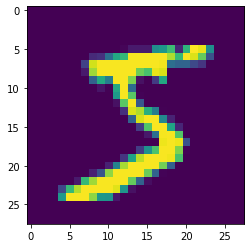

In [94]:
class SimpleDataset(Dataset):
    def __init__(self,X,y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        input = torch.tensor(self.X.iloc[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return input, targets
    
    def __len__(self):
        return self.X.shape[0]
    
dataset = SimpleDataset(X,y)
print('The dataset contains ' , len(dataset), ' samples')
example, label = dataset[0]
plt.imshow(example.reshape((28,28)))

Next, we want to create a train and test split of the data.

In [98]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset)- train_size

train_data, test_data = torch.utils.data.random_split(dataset, (train_size,test_size))
print(len(train_data))

56000
